## Network Anomaly Detection System with Hybrid ML + Rule-Based Detection
#### Requirements: pip install numpy pandas scikit-learn flask flask-socketio


In [65]:
# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import time
import random
from flask import Flask, render_template_string
from flask_socketio import SocketIO, emit
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Initialize Flask app
app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret-key'
socketio = SocketIO(app, cors_allowed_origins="*")

In [96]:
# Preparing training data
ns_data = pd.read_csv('embedded_system_network_security_dataset.csv')
sus_ports = pd.read_csv('suspicious_ports_list.csv')

In [97]:
ns_data.head()

,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False


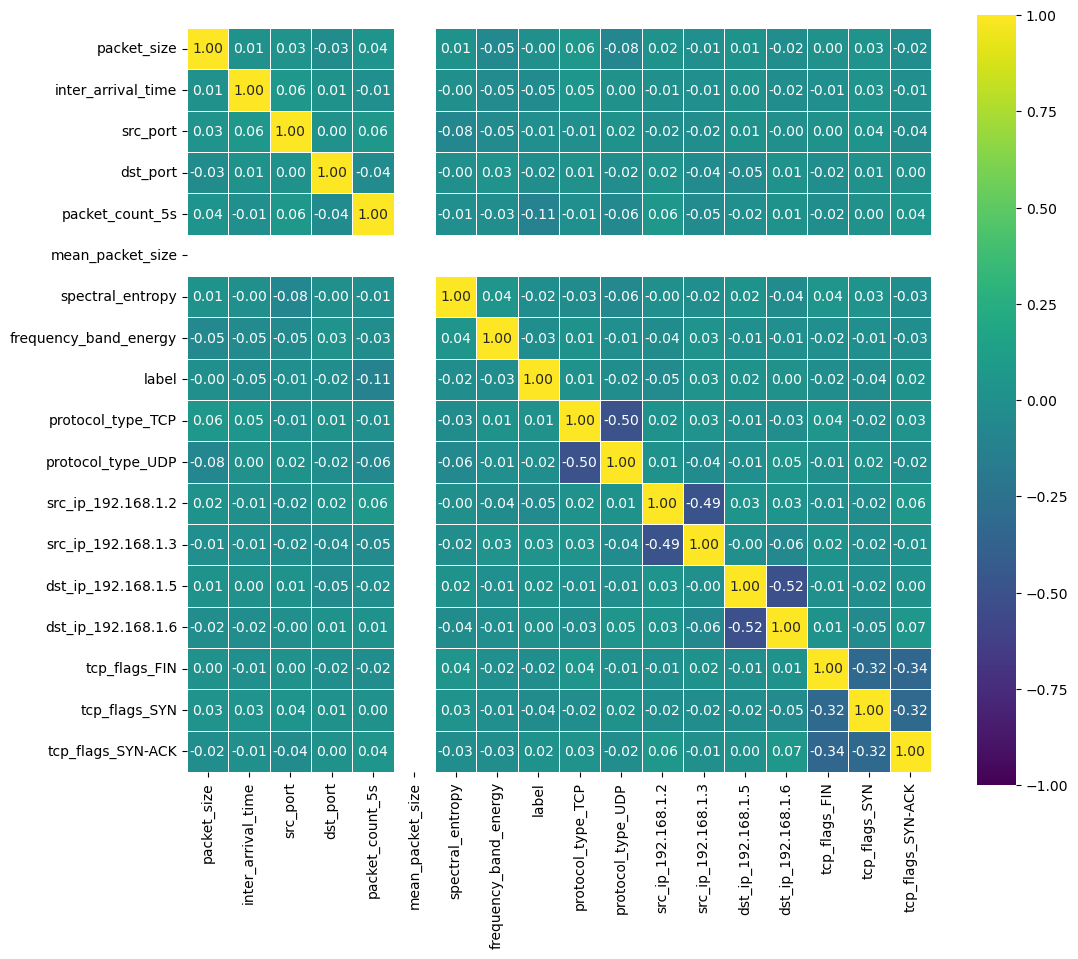

In [98]:
# Create an annotated heatmap
plt.figure(figsize = (12,10))
plt.rcParams.update({'font.size': 10})
sns.heatmap(ns_data.corr(), cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, )
plt.show()

In [103]:
from sklearn.preprocessing import OneHotEncoder
categorical_columns = list(ns_data.columns[9:])
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(ns_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))

ns_data_encoded = pd.concat([ns_data.drop(categorical_columns, axis=1), one_hot_df], axis=1)
ns_data_encoded

,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP_False,...,dst_ip_192.168.1.5_False,dst_ip_192.168.1.5_True,dst_ip_192.168.1.6_False,dst_ip_192.168.1.6_True,tcp_flags_FIN_False,tcp_flags_FIN_True,tcp_flags_SYN_False,tcp_flags_SYN_True,tcp_flags_SYN-ACK_False,tcp_flags_SYN-ACK_True
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.103794,0.078032,26435,443,0.428571,0.0,0.339083,0.402062,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
996,0.727989,0.048901,49767,80,0.928571,0.0,0.094822,0.418902,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
997,0.952756,0.731936,53507,80,0.928571,0.0,0.016880,0.441276,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.322835,0.655933,17255,53,0.071429,0.0,0.887533,0.806790,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [101]:
sus_ports.drop(columns=['metadata_link', 'metadata_reference'], inplace=True)
sus_ports = pd.DataFrame(sorted(sus_ports.values, key=lambda x: x[2]))
sus_ports

,0,1,2,3,4
0,1015,Doly trojan,high,malware,hunting
1,1042,Bla trojan,high,malware,hunting
2,1075,Backdoor.Win32.LanaFTP.k listening on this port,high,malware,hunting
3,1170,Psyber Stream Server - PSS,high,malware,hunting
4,1243,SubSeven backdoor,high,malware,hunting
...,...,...,...,...,...
224,51820,Wireguard VPN default listening port,medium,VPN,hunting
225,52935,C3 webcontroller default port,medium,C2,detection_rule
226,54320,Back Orifice backdoor,medium,malware,hunting
227,61466,Backdoor:Win32/Thething.F and telecommando trojan,medium,malware,hunting


In [ ]:
model = IsolationForest(contamination=0.2, max_samples=1.0, n_jobs=-1)

In [ ]:
# Global variables
MAX_HISTORY = 200
ml_model = None
scaler = None
traffic_history = []
anomaly_history = []
stats = {
    'total_packets': 0,
    'normal_traffic': 0,
    'anomalies_detected': 0,
    'rule_based_detections': 0,
    'ml_based_detections': 0,
    'hybrid_detections': 0,
    'threat_level': 'Low'
}

In [ ]:
# Configuration
ATTACK_TYPES = ['DDoS', 'Port Scan', 'Brute Force', 'Data Exfiltration', 'Malware C&C']
PROTOCOLS = ['TCP', 'UDP', 'ICMP', 'HTTP', 'HTTPS']

In [ ]:
class NetworkAnomalyDetector:
    def __init__(self):
        """Initialize the ML model (Isolation Forest)"""
        self.model = IsolationForest(
            contamination=0.15,  # Expected anomaly rate (tune this)
            random_state=42,
            n_estimators=100
        )
        self.scaler = StandardScaler()
        self.is_trained = False
        # define feature order explicitly and use it consistently
        self.feature_names = [
            'packet_rate',
            'byte_rate',
            'protocol_numeric',
            'time_of_day',
            'src_entropy',
            'dst_entropy',
            'packet_size_avg'
        ]

    def extract_features(self, packet):
        """Extract features from network packet (returns dict)"""
        return {
            'packet_rate': packet['packets'] / 100.0,
            'byte_rate': packet['bytes'] / 10000.0,
            'protocol_numeric': PROTOCOLS.index(packet['protocol']) / len(PROTOCOLS),
            'time_of_day': datetime.now().hour / 24.0,
            'src_entropy': self._calculate_entropy(packet['src_ip']),
            'dst_entropy': self._calculate_entropy(packet['dst_ip']),
            'packet_size_avg': packet['bytes'] / max(packet['packets'], 1)
        }


    def _calculate_entropy(self, ip_address):
        """Calculate Shannon entropy of IP address"""
        ip_str = ip_address.replace('.', '')
        if not ip_str:
            return 0.0
        entropy = 0.0
        for digit in set(ip_str):
            prob = ip_str.count(digit) / len(ip_str)
            entropy -= prob * np.log2(prob)
        return entropy / 8.0  # Normalize

    def train(self, data):
        """Train the model on historical data"""
        # require fewer samples for this demo; tune in production
        if len(data) < 20:
            return False

        feature_matrix = []
        for packet in data:
            features = self.extract_features(packet)
            # preserve the same order using self.feature_names
            feature_matrix.append([features[name] for name in self.feature_names])

        X = np.array(feature_matrix)
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled)
        self.is_trained = True
        return True

    def predict(self, packet):
        """Predict if packet is anomalous using ML"""
        if not self.is_trained:
            # Neutral prediction if not trained
            return {
                'is_anomaly': False,
                'confidence': 0.5,
                'anomaly_score': 0.0
            }

        features = self.extract_features(packet)
        X = np.array([[features[name] for name in self.feature_names]])
        X_scaled = self.scaler.transform(X)

        # IsolationForest.decision_function: higher -> more normal; negative => anomaly
        df_score = self.model.decision_function(X_scaled)[0]  # typical range depends on model
        # invert so larger => more anomalous and map to [0,1]
        # Use a scaling factor to control sensitivity (tune this, e.g. 5 or 10)
        scaled = -df_score * 5.0
        confidence = 1.0 / (1.0 + np.exp(-scaled))  # sigmoid

        is_anomaly = (self.model.predict(X_scaled)[0] == -1)

        # Clip and return
        confidence = float(np.clip(confidence, 0.0, 1.0))
        return {
            'is_anomaly': bool(is_anomaly),
            'confidence': confidence,
            'anomaly_score': float(df_score)
        }


In [ ]:

class RuleBasedDetector:
    """Traditional rule-based anomaly detection"""

    @staticmethod
    def detect(packet):
        """Detect anomalies using predefined rules (deterministic)"""
        anomaly_score = 0.0
        reasons = []

        # Rule 1: Unusually high packet count
        if packet['packets'] > 800:
            anomaly_score += 0.35
            reasons.append('High packet count')

        # Rule 2: Large data transfer
        if packet['bytes'] > 40000:
            anomaly_score += 0.35
            reasons.append('Large data transfer')

        # Rule 3: Suspicious protocol usage (ICMP floods)
        if packet['protocol'] == 'ICMP' and packet['packets'] > 300:
            anomaly_score += 0.2
            reasons.append('ICMP flood suspicion')

        # Rule 4: Very small packets but many destinations (simulated by packets < X)
        if packet['packets'] < 60 and packet['bytes'] < 2000:
            anomaly_score += 0.15
            reasons.append('Tiny packet bursts - possible scan')

        if packet['protocol'] == 'TCP' and packet['packets'] > 5000:
            anomaly_score += 0.10
            reasons.append('TCP flood suspicion')


        # Clip max
        anomaly_score = min(anomaly_score, 0.95)
        is_anomaly = anomaly_score > 0.7

        return {
            'is_anomaly': is_anomaly,
            'confidence': anomaly_score,
            'reasons': reasons if is_anomaly else []
        }


In [ ]:

class HybridDetector:
    """Combines ML and Rule-based detection"""

    @staticmethod
    def detect(packet, rule_result, ml_result):
        """Hybrid detection logic"""
        # Both methods agree - highest confidence
        if rule_result['is_anomaly'] and ml_result['is_anomaly']:
            return {
                'is_anomaly': True,
                'confidence': max(rule_result['confidence'], ml_result['confidence']),
                'detected_by': 'Both',
                'rule_score': rule_result['confidence'],
                'ml_score': ml_result['confidence']
            }

        # ML high confidence
        if ml_result['is_anomaly'] and ml_result['confidence'] > 0.80:
            return {
                'is_anomaly': True,
                'confidence': ml_result['confidence'],
                'detected_by': 'ML',
                'rule_score': rule_result['confidence'],
                'ml_score': ml_result['confidence']
            }

        # Rule high confidence
        if rule_result['is_anomaly'] and rule_result['confidence'] > 0.85:
            return {
                'is_anomaly': True,
                'confidence': rule_result['confidence'],
                'detected_by': 'Rule',
                'rule_score': rule_result['confidence'],
                'ml_score': ml_result['confidence']
            }

        # Normal traffic
        return {
            'is_anomaly': False,
            'confidence': 1 - max(rule_result['confidence'], ml_result['confidence']),
            'detected_by': 'None',
            'rule_score': rule_result['confidence'],
            'ml_score': ml_result['confidence']
        }


In [ ]:
# Initialize detectors
ml_detector = NetworkAnomalyDetector()
rule_detector = RuleBasedDetector()
hybrid_detector = HybridDetector()

In [ ]:
def generate_network_packet():
    """Generate simulated network traffic"""
    return {
        'id': time.time() + random.random(),
        'timestamp': datetime.now().strftime('%H:%M:%S'),
        'src_ip': f"192.168.{random.randint(0, 255)}.{random.randint(0, 255)}",
        'dst_ip': f"10.0.{random.randint(0, 255)}.{random.randint(0, 255)}",
        'protocol': random.choice(PROTOCOLS),
        'packets': random.randint(25, 3050),
        'bytes': random.randint(1000, 101000)
    }


In [ ]:

def process_packet(packet):
    """Process a packet through all detection systems"""
    global stats, traffic_history, anomaly_history, ml_detector, rule_detector

    # Get predictions from both systems
    rule_result = rule_detector.detect(packet)
    ml_result = ml_detector.predict(packet)
    hybrid_result = hybrid_detector.detect(packet, rule_result, ml_result)

    # Add detection results to packet
    packet.update({
        'is_anomaly': hybrid_result['is_anomaly'],
        'confidence': hybrid_result['confidence'],
        'detected_by': hybrid_result['detected_by'],
        'rule_score': hybrid_result['rule_score'],
        'ml_score': hybrid_result['ml_score'],
        'attack_type': random.choice(ATTACK_TYPES) if hybrid_result['is_anomaly'] else None
    })

    # Update statistics
    stats['total_packets'] += 1

    if packet['is_anomaly']:
        stats['anomalies_detected'] += 1
        anomaly_history.append(packet)
        anomaly_history = anomaly_history[-10:]  # Keep last 10

        if packet['detected_by'] == 'Rule':
            stats['rule_based_detections'] += 1
        elif packet['detected_by'] == 'ML':
            stats['ml_based_detections'] += 1
        elif packet['detected_by'] == 'Both':
            stats['hybrid_detections'] += 1
    else:
        stats['normal_traffic'] += 1

    # Update threat level
    anomaly_rate = (stats['anomalies_detected'] / stats['total_packets']) * 100
    if anomaly_rate > 20:
        stats['threat_level'] = 'Critical'
    elif anomaly_rate > 10:
        stats['threat_level'] = 'High'
    elif anomaly_rate > 5:
        stats['threat_level'] = 'Medium'
    else:
        stats['threat_level'] = 'Low'

    # Add to traffic history
    traffic_history.append(packet)
    traffic_history = traffic_history[-MAX_HISTORY:]

    # Train ML model periodically
    if len(traffic_history) >= 20 and not ml_detector.is_trained:
        ml_detector.train(traffic_history)
        print("ML model was trained on historical data")

    return packet


In [ ]:

def background_traffic_generator():
    """Generate network traffic in background"""
    while True:
        packet = generate_network_packet()
        processed_packet = process_packet(packet)

        # Emit to connected clients
        socketio.emit('new_packet', {
            'packet': processed_packet,
            'stats': stats,
            'anomalies': anomaly_history
        })

        time.sleep(2)  # 2 seconds interval


In [ ]:
# HTML Template with Dashboard UI
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Network Anomaly Detection System</title>
    <script src="https://cdn.socket.io/4.5.4/socket.io.min.js"></script>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body {
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
            background: #111827;
            color: #f3f4f6;
            padding: 24px;
        }
        .container { max-width: 1400px; margin: 0 auto; }
        .header {
            display: flex;
            align-items: center;
            gap: 12px;
            margin-bottom: 32px;
        }
        .header h1 { font-size: 28px; }
        .header p { color: #9ca3af; margin-top: 4px; }
        .stats-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 16px;
            margin-bottom: 24px;
        }
        .stat-card {
            background: #1f2937;
            border: 1px solid #374151;
            border-radius: 8px;
            padding: 20px;
        }
        .stat-label { color: #9ca3af; font-size: 14px; margin-bottom: 8px; }
        .stat-value { font-size: 32px; font-weight: bold; }
        .threat-low { color: #10b981; }
        .threat-medium { color: #f59e0b; }
        .threat-high { color: #f97316; }
        .threat-critical { color: #ef4444; }
        .ml-card {
            background: linear-gradient(135deg, #1e3a8a 0%, #1e40af 100%);
            border: 1px solid #3b82f6;
        }
        .section {
            background: #1f2937;
            border: 1px solid #374151;
            border-radius: 8px;
            padding: 20px;
            margin-bottom: 24px;
        }
        .section-title {
            font-size: 20px;
            font-weight: 600;
            margin-bottom: 16px;
        }
        .anomaly-item {
            background: #111827;
            border: 1px solid #7f1d1d;
            border-radius: 6px;
            padding: 12px;
            margin-bottom: 8px;
        }
        .badge {
            display: inline-block;
            padding: 4px 8px;
            border-radius: 4px;
            font-size: 11px;
            font-weight: 600;
            margin-right: 8px;
        }
        .badge-attack { background: #dc2626; color: white; }
        .badge-hybrid { background: #9333ea; color: white; }
        .badge-ml { background: #3b82f6; color: white; }
        .badge-rule { background: #06b6d4; color: white; }
        table { width: 100%; border-collapse: collapse; font-size: 14px; }
        th { text-align: left; color: #9ca3af; padding: 12px 8px; border-bottom: 1px solid #374151; }
        td { padding: 12px 8px; border-bottom: 1px solid #374151; }
        .anomaly-row { background: rgba(127, 29, 29, 0.2); }
        .ip { color: #60a5fa; }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <div>
                <h1>Hybrid Network Anomaly Detection System </h1>
                <p>Real-time monitoring with ML-powered threat detection</p>
            </div>
        </div>

        <div class="stats-grid">
            <div class="stat-card">
                <div class="stat-label">Total Packets</div>
                <div class="stat-value" id="total-packets">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Normal Traffic</div>
                <div class="stat-value" style="color: #10b981;" id="normal-traffic">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Anomalies Detected</div>
                <div class="stat-value" style="color: #ef4444;" id="anomalies">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Threat Level</div>
                <div class="stat-value" id="threat-level">Low</div>
            </div>
        </div>

        <div class="stats-grid">
            <div class="stat-card ml-card">
                <div class="stat-label" style="color: #bfdbfe;">ML Model Status</div>
                <div class="stat-value" style="color: white;" id="ml-status">Training...</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Rule-Based Detections</div>
                <div class="stat-value" style="color: #06b6d4;" id="rule-detections">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">ML Detections</div>
                <div class="stat-value" style="color: #3b82f6;" id="ml-detections">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Hybrid Confirmations</div>
                <div class="stat-value" style="color: #9333ea;" id="hybrid-detections">0</div>
            </div>
        </div>

        <div class="section">
            <div class="section-title">Recent Anomalies</div>
            <div id="anomalies-list"></div>
        </div>

        <div class="section">
            <div class="section-title">Live Traffic Feed</div>
            <table>
                <thead>
                    <tr>
                        <th>Time</th>
                        <th>Source IP</th>
                        <th>Destination IP</th>
                        <th>Protocol</th>
                        <th>Packets</th>
                        <th>Status</th>
                        <th>Method</th>
                        <th>Confidence</th>
                    </tr>
                </thead>
                <tbody id="traffic-table"></tbody>
            </table>
        </div>
    </div>

    <script>
        const socket = io();
        let trafficData = [];

        socket.on('new_packet', function(data) {
            updateStats(data.stats);
            updateAnomalies(data.anomalies);
            if (data.packet) updateTrafficTable(data.packet);
        });


        function updateStats(stats) {
            document.getElementById('total-packets').textContent = stats.total_packets.toLocaleString();
            document.getElementById('normal-traffic').textContent = stats.normal_traffic.toLocaleString();
            document.getElementById('anomalies').textContent = stats.anomalies_detected;
            
            const threatLevel = document.getElementById('threat-level');
            threatLevel.textContent = stats.threat_level;
            threatLevel.className = 'stat-value threat-' + stats.threat_level.toLowerCase();
            
            document.getElementById('rule-detections').textContent = stats.rule_based_detections;
            document.getElementById('ml-detections').textContent = stats.ml_based_detections;
            document.getElementById('hybrid-detections').textContent = stats.hybrid_detections;
            
            if (stats.total_packets >= 50) {
                document.getElementById('ml-status').textContent = 'Active';
            }
        }

        function updateAnomalies(anomalies) {
            const list = document.getElementById('anomalies-list');
            if (anomalies.length === 0) {
                list.innerHTML = '<p style="text-align: center; color: #6b7280; padding: 40px;">No anomalies detected yet...</p>';
                return;
            }
            
            list.innerHTML = anomalies.map(a => `
                <div class="anomaly-item">
                    <div style="margin-bottom: 8px;">
                        <span class="badge badge-attack">${a.attack_type}</span>
                        ${getMethodBadge(a.detected_by)}
                        <span style="color: #9ca3af; font-size: 13px;">${a.timestamp}</span>
                        <span style="float: right; font-size: 12px; background: #374151; padding: 4px 8px; border-radius: 4px;">
                            ${(a.confidence * 100).toFixed(0)}% confidence
                        </span>
                    </div>
                    <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 8px; font-size: 13px;">
                        <div><span style="color: #9ca3af;">Source:</span> <span class="ip">${a.src_ip}</span></div>
                        <div><span style="color: #9ca3af;">Dest:</span> <span class="ip">${a.dst_ip}</span></div>
                        <div><span style="color: #9ca3af;">Protocol:</span> ${a.protocol}</div>
                        <div><span style="color: #9ca3af;">Packets:</span> ${a.packets}</div>
                    </div>
                    <div style="margin-top: 8px; font-size: 12px;">
                        <span style="color: #9ca3af;">Rule Score:</span> <span style="color: #06b6d4;">${(a.rule_score * 100).toFixed(0)}%</span>
                        <span style="margin-left: 16px; color: #9ca3af;">ML Score:</span> <span style="color: #3b82f6;">${(a.ml_score * 100).toFixed(0)}%</span>
                    </div>
                </div>
            `).join('');
        }

        function getMethodBadge(method) {
            if (method === 'Both') return '<span class="badge badge-hybrid">HYBRID</span>';
            if (method === 'ML') return '<span class="badge badge-ml">ML</span>';
            if (method === 'Rule') return '<span class="badge badge-rule">RULE</span>';
            return '';
        }

        function updateTrafficTable(packet) {
            trafficData.unshift(packet);
            trafficData = trafficData.slice(0, 20);
            
            const tbody = document.getElementById('traffic-table');
            tbody.innerHTML = trafficData.map(p => `
                <tr class="${p.is_anomaly ? 'anomaly-row' : ''}">
                    <td style="color: #9ca3af;">${p.timestamp}</td>
                    <td class="ip">${p.src_ip}</td>
                    <td class="ip">${p.dst_ip}</td>
                    <td>${p.protocol}</td>
                    <td>${p.packets}</td>
                    <td>
                        <span class="badge" style="background: ${p.is_anomaly ? '#dc2626' : '#10b981'}; color: white;">
                            ${p.is_anomaly ? 'ANOMALY' : 'NORMAL'}
                        </span>
                    </td>
                    <td>${p.is_anomaly ? getMethodBadge(p.detected_by) : ''}</td>
                    <td style="color: ${p.is_anomaly ? '#f87171' : '#34d399'};">
                        ${(p.confidence * 100).toFixed(0)}%
                    </td>
                </tr>
            `).join('');
        }
    </script>
</body>
</html>
"""

In [ ]:
@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)


@socketio.on('connect')
def handle_connect():
    print('Client connected')
    emit('new_packet', {
        'packet': None,
        'stats': stats,
        'anomalies': anomaly_history
    })

In [ ]:
if __name__ == '__main__':
    # Start background traffic generator in a separate thread
    import threading
    traffic_thread = threading.Thread(target=background_traffic_generator, daemon=True)
    traffic_thread.start()

    print("\n" + "="*60)
    print("          Network Anomaly Detection System Started")
    print("="*60)
    print("Dashboard: http://localhost:8080")
    print("ML Model: Isolation Forest (scikit-learn)")
    print("Detection: Hybrid (Rule-based + ML)")
    print("="*60 + "\n")

    socketio.run(app, debug=True, host='0.0.0.0', port=8080, allow_unsafe_werkzeug=True)